# PDF Scraper
##### Yingyi Liang (Aug, 2020)
- Scrape text from PDF using distribution of text, appropriate for PDF which has similar structures each page

In [1]:
#https://stackabuse.com/working-with-pdfs-in-python-reading-and-splitting-pages/
#https://github.com/pymupdf/PyMuPDF
#doc[20].getFontList()

### 0. Imports

In [2]:
import csv
import re
import numpy as np
from numpy.random import default_rng
import pandas as pd
import fitz
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

### 1. Split text data into boxes

In [6]:
#import sample PDF
filename = "directory_1980_drug.pdf"

doc = fitz.open(filename)
print('----- {0} -----\n# of pages:\t{1}\nPage size:\t{2} * {3}'\
      .format(filename, len(doc), doc[0].bound()[2], doc[0].bound()[3]))
if (doc[0].bound()[2] != doc[10].bound()[2]):
    print('Warning: page size not uniform')

----- directory_1980_drug.pdf -----
# of pages:	172
Page size:	615.5999755859375 * 811.2000122070312


In [16]:
#no keys

In [43]:
def find_seps(coords, dist, plot = False):
    '''
    Finds gaps in coords greater than a given dist.
    Inputs:
        coords(list): list of numbers
        dist(int/float): distance between numbers to be considered a gap
        plot(boolean): if True, a histgram of the coordinates and seperation will be plotted
    Returns:
        A list of floats indication seperations.
    '''
    coords.sort()
    coords = np.array(coords)
    seps = (coords[:-1][np.diff(coords) > dist] + coords[1:][np.diff(coords) > dist])/2
    print(seps)
    seps_valid = []
    lb = 0
    for sep in seps:
        if len(coords[(coords > sep) & (coords < sep + 30)]) > 40:
            seps_valid.append(sep)
        lb = sep
    if plot:
        plt.hist(coords, bins = 100)
        for sep in seps_valid:
            plt.axvline(sep, color='black')
    return seps_valid

In [94]:
def find_seps(coords, dist, plot = False):
    '''
    Finds gaps in coords greater than a given dist.
    Inputs:
        coords(list): list of numbers
        dist(int/float): distance between numbers to be considered a gap
        plot(boolean): if True, a histgram of the coordinates and seperation will be plotted
    Returns:
        A list of floats indication seperations.
    '''
    coords.sort()
    coords = np.array(coords)
    seps = coords[1:][np.diff(coords) > dist]
    #print(seps)
    sep1 = []
    sep2 = []
    for sep in seps:
        if len(coords[(coords > sep) & (coords < sep + 20)]) > len(words)/10:
            if (sep > 190 and sep < 235):
                sep1 = [sep - 5]
            if (sep > 370 and sep < 415):
                sep2 = [sep - 5]
    seps_valid = sep1 + sep2
    if plot:
        plt.hist(coords, bins = 100)
        for sep in seps_valid:
            plt.axvline(sep, color='black')
    return seps_valid

[204.06698608398438, 386.055908203125]

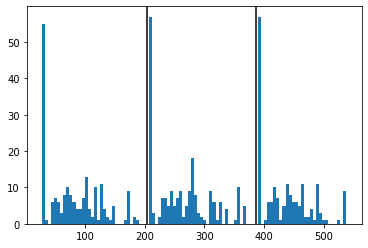

In [95]:
firstpagen = 22
words = doc[firstpagen - 1].getText("words")
find_seps([word[0] for word in words], 10, True)

[197.76702880859375]

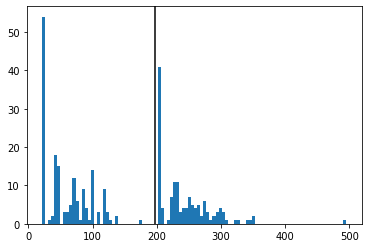

In [96]:
words = doc[39 - 1].getText("words")
find_seps([word[0] for word in words], 10, True)

### 2. Organize lines

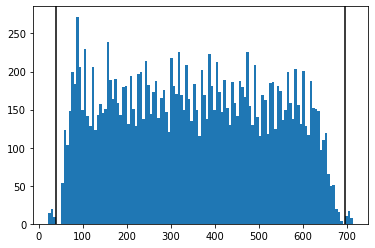

In [112]:
#check page
words = []
for pagen in range(30, 70):
    words += doc[pagen - 1].getText("words")
plt.hist([word[1] for word in words], bins = 120)
plt.axvline(40, color='black')  #cut title
plt.axvline(695, color='black') #cut page number

In [113]:
def split_rows(text, thr):
    '''
    Splits a list of into rows.
    Inputs:
        text: a list of tuple containing individual words and their positions
        thr: the distance between lines
    Outputs:
        List of list that represent rows, arranged by x0 position.
    '''
    if not text:
        return []
    
    text_remain = text
    text_by_row = []
    temp = []
    while len(text_remain) > 0:
        temp_text_remain = []
        y0 = text_remain[0][1]
        i = 0
        while i < len(text_remain):
            if (text_remain[i][1] < y0 + thr) and (text_remain[i][1] > y0 - thr):
                temp.append(text_remain[i])
            else:
                temp_text_remain.append(text_remain[i])
            i += 1
        text_remain = temp_text_remain
        temp.sort(key = lambda x: x[2]) #x[0]
        text_by_row.append(temp)
        temp = []
    text_by_row.sort(key = lambda x: x[0][1])
    return text_by_row

In [248]:
def split_units(col, dist):
    i = 0
    splitted = []
    while i < len(col):
        if i == 0:
            m = sum([word[1] for word in col[i]])/len([word[1] for word in col[i]])
            l = sum([word[1] for word in col[i + 1]])/len([word[1] for word in col[i + 1]])
            if l - m < dist:
                temp = [[word[4] for word in col[i]]]
            else:
                temp = []
        elif i < len(col) - 1:
            u = sum([word[1] for word in col[i - 1]])/len([word[1] for word in col[i - 1]])
            m = sum([word[1] for word in col[i]])/len([word[1] for word in col[i]])
            l = sum([word[1] for word in col[i + 1]])/len([word[1] for word in col[i + 1]])
            if (m - u) > dist and (l - m) > dist and len(temp) > 3:
                pass
            #    splitted.append(temp)
                #temp = []
            elif (m - u) > dist and len(temp) > 3:
                splitted.append(temp)
                temp = [[word[4] for word in col[i]]]
            else:
                temp.append([word[4] for word in col[i]])
        else:
            temp.append([word[4] for word in col[i]])
            splitted.append(temp)
        i += 1
    return [unit for unit in splitted if unit]

In [249]:
firstpagen = 19
data = []
for pagen in range(firstpagen, 170):
    words = doc[pagen - 1].getText("words")
    words = [word for word in words if word[1] > 40 and word[1] < 695]
    seps = find_seps([word[0] for word in words], 10)
    cols = []
    if not seps: #21
        cols.append([word for word in words])
    elif len(seps) == 2: #19
        cols.append([word for word in words if word[0] < seps[0]])
        cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
        cols.append([word for word in words if word[0] > seps[1]])
    else: #20
        cols.append([word for word in words if word[0] < seps[0]])
        cols.append([word for word in words if word[0] > seps[0]])
    #print(cols[0])
    page = []
    for col in cols:
        col = split_rows(col, 5)
        page.append(split_units(col, 10))
    data.append(page)

In [251]:
#data[0][0]

### 3. Write data into csv

- City, state, zip

In [198]:
def is_citystatezip(line):
    if line[-1].isnumeric() and len(line[-1]) == 5 and line[-2].isupper() and len(line[-2]) == 2 and line[-3][-1] == ',':
        return True
    return False

def clean_citystatezip(line):
    return [' '.join(line[:-2])[:-1], line[-2], line[-1]]

In [164]:
# tests = [
#     ['BIRMINGHAM,', 'AL', '35294'],
#     ['ATMORE,', 'AL', '36504']
# ]

# for t in tests:
#     print(is_citystatezip(t))
#     print(clean_citystatezip(t))

- Contact

In [173]:
def is_contact(line):
    line = ''.join(line)
    if len(line) < 12:
        return False
    if line[1:4].replace('l', '1').replace('I', '1').replace('O', '0').isnumeric()\
    and line[5:8].replace('l', '1').replace('I', '1').replace('O', '0').isnumeric()\
    and line[8] == '-':
        return True

def clean_contact(line):
    line = ''.join(line)
    c = '(' + line[1:4].replace('l', '1').replace('I', '1').replace('O', '0') + ')' + line[5:].replace('l', '1').replace('I', '1').replace('O', '0')
    return c

In [176]:
# tests = [
#     ['(2051', '251-2992']
# ]

# for t in tests:
#     print(is_contact(t))
#     print(clean_contact(t))

True
(205)251-2992


- Address

In [232]:
address_indicators = ['P.O.', 'P.0.', 'P.O', 'P.0', \
                      'ROAD', 'HIGHWAY', 'ROUTE', 'BUILDING', 'STREET', 'AVENUE', 'SUITE', 'SUITES', 'DRIVE', 'BOULEVARD', 'BLVD', \
                      'ANNEXT', 'STREETS','FLOOR', 'FL', 'BLDG', 'REAR', 'ROOM', 'BASEMENT', 'BUILDING'] ##
def is_address(line):
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

- Write to csv

In [252]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) < 2:
            print(facil)
        if len(facil) > 2:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]):##
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(clean_contact(facil[i]))
                i += 1
            else:
                data_holder.append('')
            data_holder.append(facil[i][0])
            
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [295]:
filename = "{}.csv".format(1980)
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", "Address1", "Address2", "City", "State", "ZIP_Code", "Contact", "Keys"])

In [296]:
pagen = 19

for page in data:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        if col != []:
            page_data_holders += clean_col_data(col)
            print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 19......... Finished Col ......... Finished Col ........ Finished Col 
Page: 20........ Finished Col ...... Finished Col 
Page: 21.. Finished Col 
Page: 22......... Finished Col ......... Finished Col ......... Finished Col 
Page: 23.......... Finished Col ......... Finished Col ......... Finished Col 
Page: 24...... Finished Col 
Page: 25........ Finished Col ........ Finished Col ........ Finished Col 
Page: 26.... Finished Col 
Page: 27......... Finished Col ......... Finished Col ........ Finished Col 
Page: 28........ Finished Col ......... Finished Col ........ Finished Col 
Page: 29........ Finished Col ........ Finished Col .......... Finished Col 
Page: 30......... Finished Col ........ Finished Col ........ Finished Col 
Page: 31.......... Finished Col ........... Finished Col ........... Finished Col 
Page: 32.......... Finished Col ......... Finished Col ........ Finished Col 
Page: 33.......... Finished Col ......... Finished Col ......... Finished Col 
Page: 34.....

IndexError: list index out of range

In [299]:
# #check error data
data[129 - 19][0][4]

[['(503)', '296-5452'],
 ['Alcoholism/Drug', 'Abuse', 'Treatment', 'Unit'],
 ['TXLLAMOOK'],
 ['TILLAMOOK', 'COUNTY'],
 ['COMM', 'COUNSELING', 'SERVICES', 'DRUG', 'PROGRAM'],
 ['2405', 'FIFTH', 'STREET'],
 ['TILLAMOOK,', 'OR', '97141'],
 ['(503)', '842-8201'],
 ['Drug', 'Abuse', 'Treatment', 'Unit']]

- Rewrite data in problem pages

In [71]:
pagen = 77
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
seps = [190, 375]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [274]:
pagen = 96
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [190, 375]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [279]:
pagen = 97
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [190, 370]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [294]:
data[107 - 19][1][5] = [['CITY', 'OF', 'BUFFALO', 'OHR'],
 ['ELLICOTT/MASTEN', 'COMM', 'COUNSELING', 'CENTER'],
 ['560', '-', '562', 'WILLIAM', 'STREET'],
 ['BUFFALO,', 'NY', '14204'],
 ['I716l', '855-4069'],
 ['Drug', 'Abuse', 'Treatment', 'Unit']]

data[107 - 19][2][2] = [['MENTAL', 'HEALTH', 'SERVICES', 'CORP', 'VI'], ['LOWER', 'WEST', 'SIDE', 'DRUG', 'ABUSE', 'PROGRAM'],
                        ['485', 'NIAGARA', 'STREET'], ['BUFFALO,', 'NY', '14201'],
                       ['I716l', '856-2000'], ['Drug', 'Abuse', 'Treatment', 'Unit']]

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [302]:
df = pd.read_csv("{}.csv".format(1980))
df

,Name1,Name2,Address1,Address2,City,State,ZIP_Code,Contact,Keys
0,ALEXANDER CITY WORK RELEASE CENTER,NaN,P.O. BOX 705,NaN,ALEXANDER CITY,AL,35010,(205)234-7533,Drug
1,CALHOUN-CLEDURNE MENTAL HEALTH CENTER,SUBSTANCE ABUSE PROGRAM,331 EAST EIGHTH AVENUE,NaN,ANNISTON,AL,36202,(205)236-3403,Alcoholism/Drug
2,BOARD OF CORRECTIONS DRUG ABUSE,PROGRAM FOR ALABAMA INMATES,313 NORTH MAIN,P.O. BOX 266,ATMORE,AL,36504,(205)368-1675,Drug
3,BESSEMER OUTPATIENT TREATMENT CENTER,NaN,1830 THIRD AVENUE,SUITE 308,BESSEMER,AL,35020,(205)426-8020,Drug
4,ALETHEIA HOUSE INC,NaN,3600 EIGHTH AVENUE SOUTH,SUITE W-110,BIRMINGHAM,AL,35222,(205)324-6502,Drug
...,...,...,...,...,...,...,...,...,...
2312,CODA DRUG TREATMENT SERVICES,NaN,7305 NORTHEAST GLISAN,NaN,PORTLAND,OR,97213,(503)257-0533,Drug
2313,FREEDOM HOUSE INC,NaN,1531 NE 21ST STREET,NaN,PORTLAND,OR,97232,(503)288-2331,Drug
2314,OREGON METHADONE TREATMENT PROGRAM,NaN,306 NE 20TH,NaN,PORTLAND,OR,97232,(503)239-8400,Drug
2315,THOMAS E DORSEY PHO PSYCHOLOGIST,AO-AFTERCARE UNIT,2738 NORTHEAST BROADWAY,NaN,PORTLAND,OR,97232,(503)249-0041,Drug


In [303]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[5])!=2:
        print(index)

35
101
128
129
130
319
325
408
409
433
457
487
488
508
511
528
545
622
716
717
737
746
747
762
782
886
892
898
951
963
1005
1016
1046
1047
1090
1142
1143
1155
1161
1163
1165
1166
1204
1347
1350
1366
1376
1459
1465
1470
1476
1482
1512
1521
1564
1616
1617
1618
1619
1677
1819
1860
1862
1958
1972
1973
2020
2080
2110
2144
2207
2214
2223
2259
2266
2282
2297


In [120]:
#check if all zip codes are correct
df.dtypes

Name1        object
Name2        object
Name3        object
Address1     object
Address2     object
Address3     object
City         object
State        object
ZIP_Code     object
Contact      object
Website     float64
Note         object
Keys         object
dtype: object

- Correct in Pandas

In [305]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'AND':
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [306]:
# def split_zip(zipc):
#     if '-' in zipc:
#         return zipc.split('-')
#     return [zipc, None]
# #split zip-code if zip code is in the format xxxxx-xxxx
# df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
# df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [308]:
df.to_csv('{}_c.csv'.format(1980), index = False)